# `ORBIT5K` dataset

**Authors:** Olympio Hacquard and Vadim Lebovici

**Date:** March 2023

-----

In [10]:
import sys
sys.path.append('../')

# Generating dataset
The function `gen_orbit5K` from `eulearning.datasets` generates the full `ORBIT5K` dataset by default.

In [11]:
from eulearning.datasets import gen_orbit5K

rhos = [2.5, 3.5, 4.0, 4.1, 4.3]
n_pt_clds_per_class = 1000

n_classes = len(rhos)
n_pt_clds = n_classes*n_pt_clds_per_class

X, y = gen_orbit5K(rhos=rhos, size_each=n_pt_clds_per_class)

We can now plot an example of point cloud for each class:

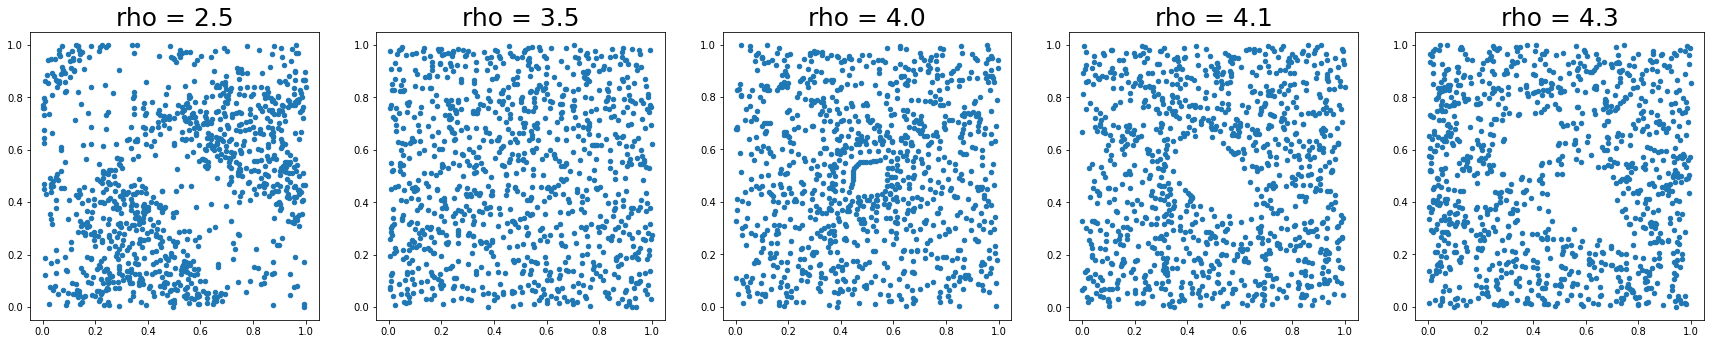

In [2]:
import matplotlib.pyplot as plt

plt.figure()
for k, rho in enumerate(rhos):
	plt.subplot(1,5,k+1)
	plt.scatter(X[k*n_pt_clds_per_class,:,0], X[k*n_pt_clds_per_class,:,1], s=20)
	plt.title('rho = %s' %rho, fontsize=25)
plt.subplots_adjust(bottom=0, right=4, top=1)
plt.show()

# Computing multi-parameter filtrations
We compute the alpha complexes, the codensity filtration and vectorize the simplex trees.

In [12]:
import numpy as np
import gudhi as gd
from eulearning.utils import codensity, vectorize_st

vec_sts = []
for _ in range(n_pt_clds):
	ac = gd.AlphaComplex(X[_])											# Initialize the alpha complex
	st = ac.create_simplex_tree() 										# Compute the alpha filtration
	X_ = np.array([ac.get_point(i) for i in  range(st.num_vertices())]) # For technical reasons, computation of the alpha complex may change the order of vertices
	codensity_filt = codensity(X_)										# Compute codensity of each point cloud
	vec_st = vectorize_st(st, filtrations=[codensity_filt])				# Vectorize the simplex tree
	vec_sts.append(vec_st)

# Computing Euler characteristic descriptors
We compute the Euler characteristic profiles of the above multi-filtrations, as well as their Radon transform and hybrid transforms.

### Euler characteristic profiles

In [13]:
from eulearning.descriptors import EulerCharacteristicProfile

euler_profile = EulerCharacteristicProfile(resolution=(30,30), quantiles=[(0.2, 0.8), (0.1,0.9)], pt_cld=True) # ECPs are flatten by default to fit with sklearn classifiers. Set flatten=False to unflatten them.
ecps = euler_profile.fit_transform(vec_sts)

We can now plot some examples.

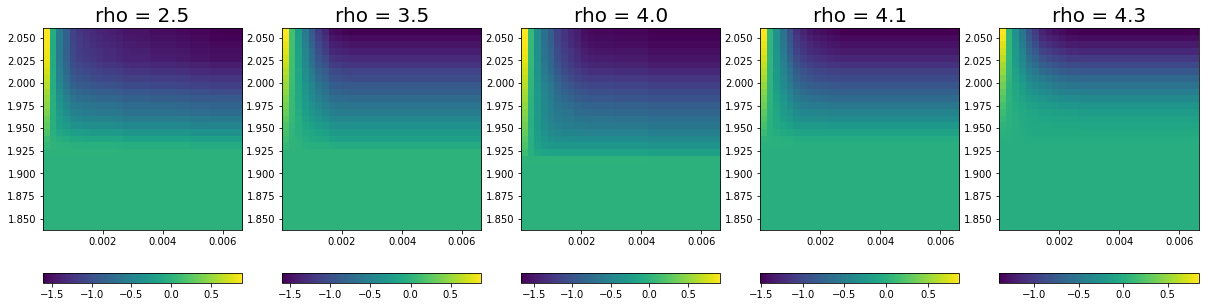

In [14]:
extent = list(euler_profile.val_ranges[0])+list(euler_profile.val_ranges[1])
plt.figure()
for k, rho in enumerate(rhos):
	plt.subplot(1,5,k+1)
	ecp = ecps[k*n_pt_clds_per_class].reshape(euler_profile.resolution) 				# Unflatten the ECPs
	plt.imshow(ecp, origin='lower', extent=extent, aspect='auto')
	plt.title('rho = %s' %rho, fontsize=20)
	plt.colorbar(orientation='horizontal')
plt.subplots_adjust(bottom=0, right=2.8, top=1)
plt.show()

### Radon transforms

In [6]:
from eulearning.descriptors import RadonTransform

radon_transform = RadonTransform(resolution=(30,30), val_ranges=[(0, 5000), (0, 0.53)], pt_cld=True)
rdns = radon_transform.fit_transform(vec_sts)

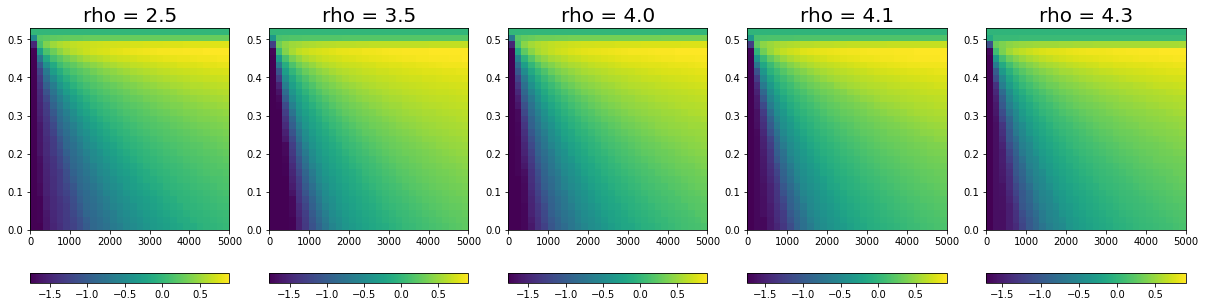

In [7]:
extent = list(radon_transform.val_ranges[0])+list(radon_transform.val_ranges[1])
plt.figure()
for k, rho in enumerate(rhos):
	plt.subplot(1,5,k+1)
	rdn = rdns[k*n_pt_clds_per_class].reshape(radon_transform.resolution) 				# Unflatten the Radon transforms
	plt.imshow(rdn, origin='lower', extent=extent, aspect='auto')
	plt.title('rho = %s' %rho, fontsize=20)
	plt.colorbar(orientation='horizontal')
plt.subplots_adjust(bottom=0, right=2.8, top=1)
plt.show()

### Hybrid transforms

In [8]:
from eulearning.descriptors import HybridTransform

hybrid_transform = HybridTransform(resolution=(30,30), val_ranges=[(0, 2000), (0, 0.65)], kernel_name='wavelet_8', pt_cld=True)
hts = hybrid_transform.fit_transform(vec_sts)

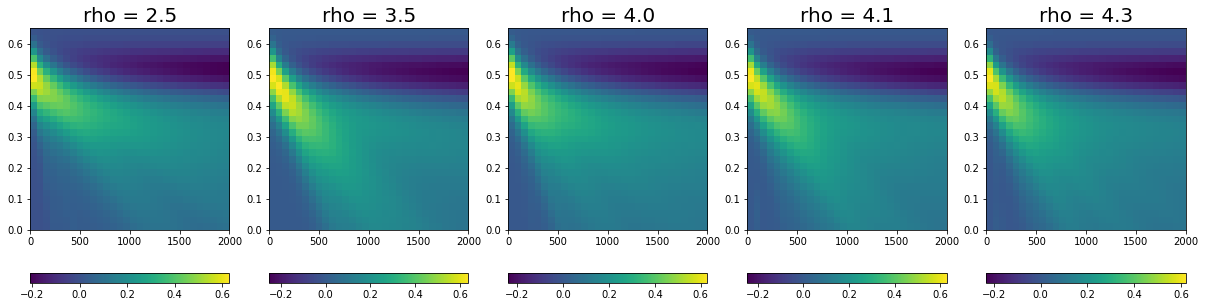

In [9]:
extent = list(hybrid_transform.val_ranges[0])+list(hybrid_transform.val_ranges[1])
plt.figure()
for k, rho in enumerate(rhos):
	plt.subplot(1,5,k+1)
	ht = hts[k*n_pt_clds_per_class].reshape(hybrid_transform.resolution) 				# Unflatten the hybrid transforms
	plt.imshow(ht, origin='lower', extent=extent, aspect='auto')
	plt.title('rho = %s' %rho, fontsize=20)
	plt.colorbar(orientation='horizontal')
plt.subplots_adjust(bottom=0, right=2.8, top=1)
plt.show()

# Classifying `ORBIT5K`

In [16]:
from sklearn.model_selection 	import train_test_split
from xgboost					import XGBClassifier

clf = XGBClassifier()

# Classifying using Euler characteristic profiles
ecps_train, ecps_test, y_train, y_test = train_test_split(ecps, y, test_size=0.3)
clf.fit(ecps_train, y_train)
ecps_score = clf.score(ecps_test, y_test)
print('ECPs score:', np.round(ecps_score*100, decimals=2), '%')

# Classifying using Radon transforms
rdns_train, rdns_test, y_train, y_test = train_test_split(rdns, y, test_size=0.3)
clf.fit(rdns_train, y_train)
rdns_score = clf.score(rdns_test, y_test)
print(' RTs score:', np.round(rdns_score*100, decimals=2), '%')

# Classifying using hybrid transforms
hts_train, hts_test, y_train, y_test = train_test_split(hts, y, test_size=0.3)
clf.fit(hts_train, y_train)
hts_score = clf.score(hts_test, y_test)
print(' HTs score:', np.round(hts_score*100, decimals=2), '%')

ECPs score: 76.67 %
 RTs score: 64.0 %
 HTs score: 84.67 %
